In [1]:
import numpy as np
import sunode
import sympy as sym
import matplotlib.pyplot as plt

import sunode.symode.paramset
import sunode.symode.problem
import sunode.wrappers.as_theano

import theano
import theano.tensor as tt

### Define ode using sympy

In [2]:
def make_ode(*, ode_error_order=None):
    assert ode_error_order is None # TODO
    paramset = sunode.symode.paramset.ParamSet(
        [
            ('a', True),
            ('b', True),
            ('c', True),
            ('d', False),
            ('e', False),
            ('f', [
                ('g', False, (3,))
            ])
        ],
        {
            'a': 0.1,
            'b': 0.22,
            'c': 0.11,
            'd': 0.1,
            'e': 0.5,
            'f': {
                'g': np.ones(3)
            }
        }
    )

    states = {
        'x': (),
        'y': (),
    }
    
    def rhs_sympy(t, y, params):
        return {
            'x': y.y,
            'y': params.b,
        }

    return sunode.symode.problem.SympyOde(paramset, states, rhs_sympy)

In [3]:
ode = make_ode()

tvals = np.linspace(0, 10, 20)
y0 = np.ones(ode.n_states)

### Solve without gradients

92.8 µs ± 800 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


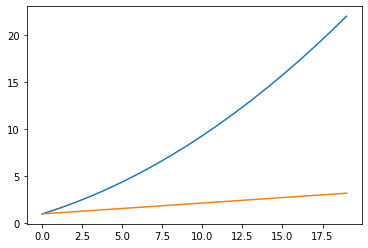

In [4]:
solver = sunode.solver.Solver(ode)
out = solver.make_output_buffers(tvals)
solver.solve(0, tvals, y0, out)
%timeit solver.solve(0, tvals, y0, out)
plt.plot(out);

### Solve with sensitivities

In [5]:
#solver = sunode.solver.Solver(ode, compute_sens=True)
#out = solver.make_output_buffers(tvals)
#solver.solve(0, tvals, y0, out)
#%timeit solver.solve(0, tvals, y0, out)
#plt.plot(out);

### Solve with adjoint

In [6]:
solver = sunode.solver.AdjointSolver(ode)
out, grad_out, lamda_out = solver.make_output_buffers(tvals)

grads = np.ones(out.shape)
grads[:, 0] = 0

In [7]:
%%timeit
solver.solve_forward(0, tvals, y0, out)
solver.solve_backward(tvals[-1], 0, tvals, grads, grad_out, lamda_out)

336 µs ± 4.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Integrate into theano and check gradients

In [8]:
tvals = np.arange(1, 10)

In [9]:
params = tt.dvector('params')
y0 = tt.dvector('y0')
solve_ode = sunode.wrappers.as_theano.SolveODEAdjoint(solver, 0, tvals)
solution = solve_ode(y0, params)

loss = (solution ** 2).sum()
grad_p, grad_y0 = tt.grad(loss, [params, y0])
func = theano.function([y0, params], [loss, grad_p, grad_y0])

# Explicit solution
loss = ((
    ((0.5 * tvals ** 2 * params[1] + tvals * y0[1]) + y0[0]) ** 2
    + (tvals * params[1] + y0[1]) ** 2
)).sum()
grad_p, grad_y0 = tt.grad(loss, [params, y0])

func2 = theano.function([y0, params], [loss, grad_p, grad_y0])

In [10]:
p = np.random.randn(3)
y0 = np.random.randn(2)
func(y0, p)

[array(15966.33984513),
 array([     0.        , -16215.25009364,      0.        ]),
 array([ -552.40946791, -4143.94867923])]

In [11]:
func2(y0, p)

[array(15966.33984513),
 array([     0.        , -16215.25009351,      0.        ]),
 array([ -552.40946791, -4143.94867923])]

In [12]:
eps = 1e-8
h = np.zeros_like(y0)
h[0] += eps
a = func(y0, p)
b = func(y0 + h, p)

In [13]:
print((b[0] - a[0]) / h)
print(a[2])

[-552.41143855          -inf]
[ -552.40946791 -4143.94867923]


In [14]:
eps = 1e-8
h = np.zeros_like(p)
h[1] += eps
a = func(y0, p)
b = func(y0, p + h)

In [15]:
print((b[0] - a[0]) / h)
print(a[1])

[           -inf -16215.25061637            -inf]
[     0.         -16215.25009364      0.        ]


### Use in pymc3

In [16]:
import pymc3 as pm

with pm.Model() as model:
    params = pm.Normal('params', sd=10, shape=ode.n_params)
    y0 = pm.Normal('y0', shape=ode.n_states)
    
    solve_ode = sunode.wrappers.as_theano.SolveODEAdjoint(solver, 0, tvals)
    mu = solve_ode(y0, params)
    error = 0.8 * np.random.randn(len(tvals))
    pm.Normal('y', mu=mu[:, 0], sd=0.8, observed=tvals ** 2 + tvals + 5 + error)
    
    trace = pm.sample(chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, params]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:28<00:00, 71.26draws/s] 


In [17]:
with model:
    tr = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:00<00:00, 1596.47it/s]


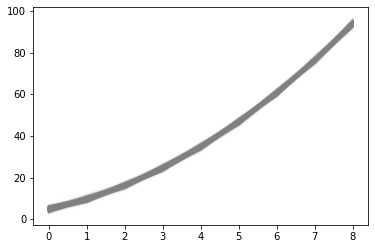

In [18]:
plt.plot(tr['y'].T, color='grey', alpha=0.01);

In [19]:
import seaborn as sns

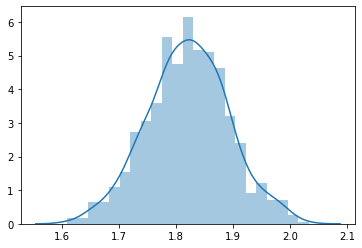

In [20]:
sns.distplot(trace['params'][:, 1])

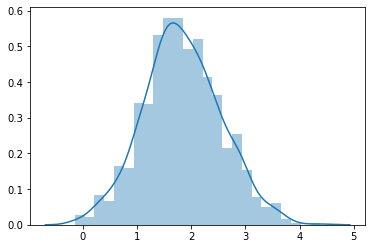

In [21]:
sns.distplot(trace['y0'][:, 0])